# Домашнее задание 3

## Камаев Виктор БИБ214

### Задание 1. EM-алгоритм

In [349]:
import numpy as np
import pandas as pd
import warnings

# warnings.filterwarnings('ignore')

#### 1. Импортируем датасет

In [350]:
from sklearn.datasets import load_wine

data = load_wine(as_frame=True)

X = data['data'].to_numpy()
y = data['target'].to_numpy()

#### 2. Переписываем EM из семинара

In [351]:
import math

# запишем функцию E-шага
def e_step(X: np.ndarray, k: int, w, mu, sigma):
    # инициализируем массив плотностей вероятностей извлечения i-того объекта из j-го класса
    pj_xi = []
    for j in range(k):
        det_sigma_j = np.linalg.det(sigma[j])
        factor_1 = 1 / (((2 * math.pi)**(k/2)) * (det_sigma_j**0.5))
        factor_2 = []
        for i in X:
            factor_2.append(math.e**float(
                -0.5 * np.matrix(i - mu[j]) * np.matrix(np.linalg.inv(sigma[j])) * np.matrix(i - mu[j]).T))
        pj_xi.append(factor_1 * np.array(factor_2))

    pj_xi = np.array(pj_xi)
    
    # инициализируем массив плотностей вероятностей того, что i-тый объект относится к j-му классу 
    pj_xi_w = np.array([pj_xi[j] * w[j] for j in range(k)])
    
    # рассчитаем плотность вероятности извлечения i-того объекта среди всех объектов  
    sum_pj_xi_w = np.sum(pj_xi_w, axis=0)
    
    # инициализируем массив вероятностей отнесения каждого объекта к каждому классу
    proba_xi = np.array([pj_xi_w[j] / sum_pj_xi_w for j in range(k)])
    
    return proba_xi

# на основании вероятностей получаем массив предсказаний
# argmax отдает массив, где для каждого элемента i выдает индекс класса, где вероятность максимальная
# то есть максимум по нулевой оси
def x_new(proba_xi):
    return np.argmax(proba_xi, axis=0)


# запишем функцию M-шага
def m_step(x, proba_xi):
    w_new = np.mean(proba_xi, axis=1)
    
    # рассчитаем математическое ожидание
    mu_new = (np.array((np.matrix(proba_xi) * np.matrix(x))).T / np.sum(proba_xi, axis=1)).T

    # рассчитаем дисперсии
    cov_new = []
    for mu in range(mu_new.shape[0]):
        X_cd = []
        X_cd_proba = []
        count = 0
        
        for x_i in x:
            cd = np.array(x_i - mu_new[mu])
            X_cd.append(cd)
            X_cd_proba.append(cd * proba_xi[mu][count])
            count += 1

        X_cd = np.array(X_cd).reshape(x.shape)
        X_cd_proba = np.array(X_cd_proba).reshape(x.shape)

        cov_new.append(np.matrix(X_cd.T) * np.matrix(X_cd_proba))

    cov_new = np.array(cov_new)

    # for i in range(mu_new.shape[0]):
    #     cov_new[i] = cov_new[i] / (np.sum(proba_xi, axis=1)-1)[i]
    cov_new = np.array((np.array(cov_new) / (np.sum(proba_xi, axis=1)-1)))

    # при расчете матрицы ковариации в некоторых случаях могут быть элементы с отрицательными значениями, переведем их в нули
    # на основной рассчет такой перевод не повлияет, но упростит извлечение корня из значений матрицы ковариации
    cov_new = np.clip(cov_new, a_min=0, a_max=None)
    
    # рассчитаем стандартное отклонение
    sigma_new = cov_new**0.5
    return w_new, mu_new, sigma_new

#### 3. Функция для обучения + сходимость

In [352]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

Отнормализуем данные

In [353]:
X_new = StandardScaler().fit_transform(X)

Также чтобы побороть то, что матрицы улетают в 0/NaN, выберем 3 самых значимых признака с помощью `SelectKBest`

In [354]:
k = 3

X_new = SelectKBest(f_classif, k=k).fit_transform(X_new, y)

Теперь напишем функцию обучения

Для сходимости выберем критерий:
- либо случилось переполнение
- либо превышено максимальное количество итераций
- либо метрика упала

In [378]:
def Full_EM(X: np.ndarray, k: int, map_dict: dict[int, int] = None, max_steps=10):
    np.random.seed(42)
    n, m = X.shape

    # инициализируем параметры
    w = np.array([1 / k] * k)
    mu = np.array([np.mean(X[np.random.choice(n, int(n/k))], axis=0) for _ in range(k)])
    sigma = np.array([np.eye(m) * 1000] * k)

    acc_prev = None
    X_answers_prev = None

    # запустим цикл EM-алгоритма
    for i in range(max_steps):
        proba_xi = e_step(X, k, w, mu, sigma)
        w, mu, sigma = m_step(X, proba_xi)
        X_answers = x_new(proba_xi)

        if map_dict:
            X_answers = map_answers(X_answers, map_dict) # объяснение функции чуть ниже
            
        acc = accuracy_score(y, X_answers)

        if np.isnan(sigma).any() or acc_prev and acc < acc_prev:  # проверка на сходимость
            print(f'[Iter {i + 1}]: accuracy dropped')
            return acc_prev, X_answers_prev
        
        print(f'[Iter {i + 1}] acc =', round(acc,3))
        acc_prev = acc
        X_answers_prev = X_answers

    print(f'Max steps ({max_steps}) is reached')
    return acc, X_answers

Так как ЕМ-алгоритм работает харашо для кластеризации, а не классификации, то он делит выборку на классы **не вникая** в то, какой номер они имеют

То есть первый класс может оказаться вторым, второй нулевым и.т.д.

Чтобы с этим бороться нужно смотреть на ответы и вручную мапить классы. Для этого есть функция ниже. Она для выбранного мапания возвращает новый массив ответов

In [372]:
def map_answers(X, m: dict[int, int]):
    return np.array(list(map(lambda x: m[int(x)], X)))

In [379]:
from itertools import permutations

def get_best_ans(X, k):
    best_map, best_acc, best_ans = None, 0, None

    for perm in permutations(range(k)):
        map_dict = dict(zip(range(k), perm))
        print(map_dict)

        acc, ans = Full_EM(X, k, map_dict, 10)
        
        if acc > best_acc:
            best_map = map_dict
            best_acc = acc
            best_ans = ans
        print()

    print(f'Best map: {best_map} with accuracy {best_acc}')

    return best_ans

In [380]:
ans = get_best_ans(X_new, k)

{0: 0, 1: 1, 2: 2}
[Iter 1] acc = 0.506
[Iter 2]: accuracy dropped

{0: 0, 1: 2, 2: 1}
[Iter 1] acc = 0.388
[Iter 2]: accuracy dropped

{0: 1, 1: 0, 2: 2}
[Iter 1] acc = 0.607
[Iter 2] acc = 0.691
[Iter 3]: accuracy dropped

{0: 1, 1: 2, 2: 0}
[Iter 1] acc = 0.236
[Iter 2] acc = 0.275
[Iter 3] acc = 0.315
[Iter 4] acc = 0.337
[Iter 5] acc = 0.354
[Iter 6]: accuracy dropped

{0: 2, 1: 0, 2: 1}
[Iter 1] acc = 0.258
[Iter 2] acc = 0.275
[Iter 3] acc = 0.287
[Iter 4] acc = 0.303
[Iter 5] acc = 0.309
[Iter 6] acc = 0.331
[Iter 7]: accuracy dropped

{0: 2, 1: 1, 2: 0}
[Iter 1] acc = 0.006
[Iter 2] acc = 0.011
[Iter 3] acc = 0.062
[Iter 4] acc = 0.14
[Iter 5] acc = 0.242
[Iter 6] acc = 0.264
[Iter 7] acc = 0.315
[Iter 8] acc = 0.343
[Iter 9]: accuracy dropped

Best map: {0: 1, 1: 0, 2: 2} with accuracy 0.6910112359550562


#### 4. Оценка качества модели

In [359]:
print(classification_report(y, ans))

              precision    recall  f1-score   support

           0       0.96      0.46      0.62        59
           1       0.60      0.69      0.64        71
           2       0.69      0.98      0.81        48

    accuracy                           0.69       178
   macro avg       0.75      0.71      0.69       178
weighted avg       0.74      0.69      0.68       178



Видим, что accuracy получилась равна 0.7, что довольно неплохо

Однако если посмотреть на распределение метрик по классам, все не так гладко

- Нулевой класс угадывался наиболее точно (precision), а остальные не очень
- Второй класс угадывался наиболее полно (recall), нулевой класс угадывался редко
- F1-мера у второго класса получилась значительно больше, чем у остальных

#### 5. Gaussian Mixture

In [360]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report

In [361]:
np.random.seed(42)

best_map, best_acc, best_ans = None, 0, None
pred = GaussianMixture(n_components=k).fit_predict(X_new, y)

for perm in permutations(range(k)):
    map_dict = dict(zip(range(k), perm))

    ans = map_answers(pred, map_dict)
    acc = accuracy_score(y, ans)

    if acc > best_acc:
        best_map = map_dict
        best_acc = acc
        best_ans = ans

print(f'Best map: {best_map} with accuracy {best_acc}')

Best map: {0: 1, 1: 2, 2: 0} with accuracy 0.9325842696629213


In [370]:
print(classification_report(best_ans, y))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        64
           1       0.85      0.98      0.91        61
           2       1.00      0.91      0.95        53

    accuracy                           0.93       178
   macro avg       0.94      0.93      0.93       178
weighted avg       0.94      0.93      0.93       178



Здесь распределение по метрика почти одинаковое у всех классов, а метрика 0.93 - супер хорошо

Разве что первый класс угадывался наименее точно, но наиболее полно, но все равно хуже остальных по f1-мере

### Задание 2. KNN

#### 1. Датасет уже импортирован

#### 2. Методы кросс-валидации при обычных данных

In [363]:
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, BaseCrossValidator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import defaultdict

kf = KFold(shuffle=True, random_state=42)
skf = StratifiedKFold(shuffle=True, random_state=42)
loo = LeaveOneOut()

selectors = [kf, skf, loo]

k_max = 50

Так как вторая часть задания подразумевает аналогичные действия, создадим функцию для получения всех accuracy для  каждого селектороа(метода кросс-валидации) из списка

Функция будет возвращать словарь, где ключ - имя селектора, значение - массив из accuracy для каждого значения соседей из интервала $[1; k_{max} + 1]$

In [364]:
def get_selectors_scores(selectors: list[BaseCrossValidator], 
                         X: np.ndarray, 
                         y: np.ndarray, 
                         k_max: int):
    
    results = defaultdict(list)

    for k in range(1, k_max + 1):
        clf = KNeighborsClassifier(n_neighbors=k)
        for s in selectors:
            folds = s.split(X, y)

            acc, n_folds = 0, 0

            for train_ind, test_ind in folds:
                X_train, X_test = X[train_ind], X[test_ind]
                y_train, y_test = y[train_ind], y[test_ind]

                clf.fit(X_train, y_train)
                pred = clf.predict(X_test)

                acc += accuracy_score(y_test, pred)
                n_folds += 1

            acc /= n_folds

            results[s.__class__.__name__].append(acc)

    return results

In [365]:
results_non_scaled = get_selectors_scores(selectors, X, y, k_max)

Теперь создадим функцию для отрисовки графика

В названии будем отображать лучший селектор, а также значение числа соседей при котором достигается лучшая точность

In [366]:
import matplotlib.pyplot as plt

def plot(results: dict[str, list[float]], k_max: int):
    
    plt.figure(figsize=(15, 5))

    best_selector, best_score, best_k = '', 0, 0

    k_range = range(1, k_max + 1)

    for s_name, res in results.items():
        plt.plot(k_range, res, label=s_name)

        i, best = max(enumerate(res), key=lambda x: x[1])
        if best > best_score:
            best_selector = s_name
            best_score = best
            best_k = i + 1

    plt.title(f'Best selector: {best_selector} (k = {best_k}, accuracy = {round(best_score, 3)})')

    plt.legend()
    plt.show()

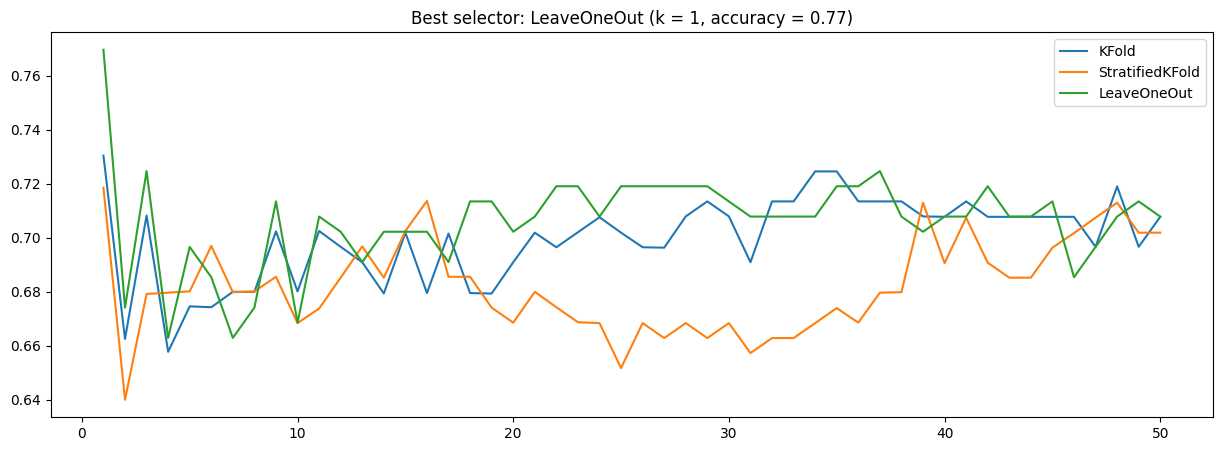

In [367]:
plot(results_non_scaled, k_max)

Видим, что все селекторы показали себя лучше себя при $k=1$ - очень не очень. Но `LeaveOneOut` выделяется и оказался лучшим

Точность получилась 0.77, что примлемо


#### 3. Методы кросс-валидации при масштабированных данных

Теперь посмотрим на то, что получится, если отмасштабировать данные

In [368]:
from sklearn.preprocessing import scale

results_scaled = get_selectors_scores(selectors, scale(X), y, k_max)

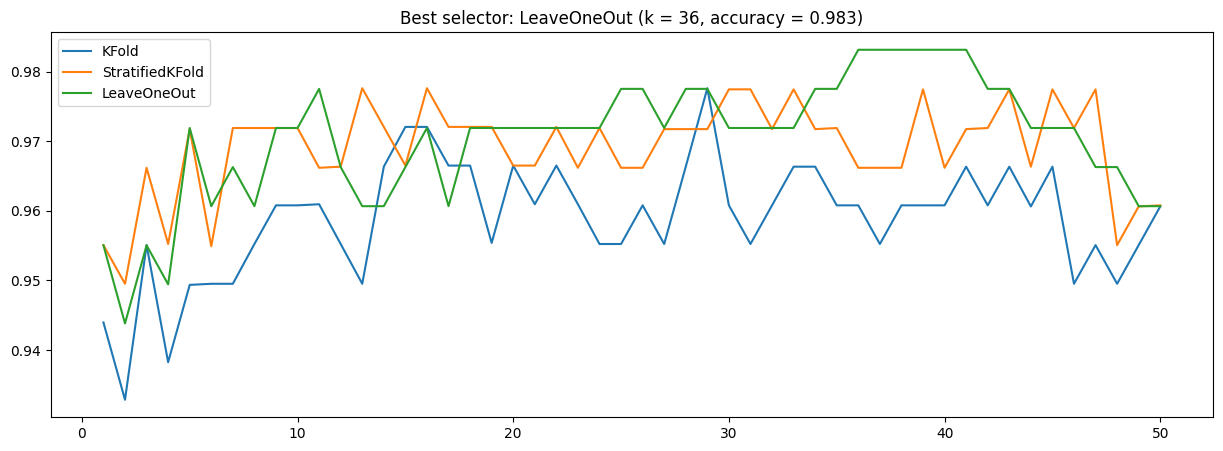

In [369]:
plot(results_scaled, k_max)

Видим значительный прирост качества. Accuracy ниже чем 0.93 нет ни при одном селекторе

Однако лучше всего показал себя опять `LeaveOneOut` при $k=36$. При этом точность 0.98, что почти 100%. 

Таким образом:
- масштабирование данных дало значительный прирост в качестве классификатора (плюс целых 0.2)
- оптимальное значение числа соседей теперь не 1, а 36
- оптимальный селектор все также `LeaveOneOut`
- для других селекторов оптимальное значение $k=29$